In [245]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from math import ceil
import random

import importlib

import ray_tracing_utils
importlib.reload(ray_tracing_utils)
import ray_tracing_utils as rt

import ray_tracing_constants
importlib.reload(ray_tracing_constants)
import ray_tracing_constants as rtc
from collections import deque #to implement stack
from os.path import join, exists



from Arrow3D import _arrow3D
setattr(Axes3D, 'arrow3D', _arrow3D)

# Cox & Munk
## Statistical distribution of the random sea surface slopes

Statistical distribution of the random sea surface slopes (a bivariate Gaussian). Cox-Munk statistics include capillary waves and gravity waves.

$$ p(\eta_a,\eta_c) = \frac{1}{2\pi \sigma_a \sigma_c}\exp[-\frac{1}{2}(\frac{\eta_a^2}{\sigma^2_a} + \frac{\eta^2_c}{\sigma^2_c})]$$

$p(\eta_a,\eta_c)$ is normalised such that the area under it is 1

where $\eta$ is the wave elevation, distributed normally with zero mean and variance, $\eta_a$ and $\eta_c$ are the along-wind (upwind) and crosswind slopes of the water surface respectively. 
$\eta_a = \frac{\delta \eta}{\delta x_a}, \eta_c = \frac{\delta \eta}{\delta x_c}$. 
It is known from experiment that the capillary wave slopes $\eta_a$ and $\eta_c$ vary in a random manner, being independently and normally distributed with zero mean and variances.

## Wave-slope wind-speed law

### Cox-Munk Capillary wave slope equations

- It should be emphasized that they also represent the *slopes* of a gravity-capillary wave surface. Most of the variance in the slope of the sea surface is due to the shortest wavelength of capillary waves. 
- Most of the variance in the *amplitude* of the surface waves id due to the longest gravity waves.
- For optics, it is the *slope* of the surface that is the most important because the slope determines the angles entering the Fresnel reflectance equations for an incident ray.
- The amplitude of the waves determines the amount of wave "shadowing" at low solar elevations and influences multiple scattering between gravity waves, but the effects are insignificant unless viewing from near-horizon sun positions

$\sigma^2_a = a_a U,$ where $a_u = 3.16\times 10^{-3} s/m$

$\sigma^2_c = a_c U$, where $a_c = 1.92\times 10^{-3} s/m$



These slope variances were found to be related to the wind speed $U$ which is the wind speed (in m/s) measured at an anemometer height of 12.5 m above mean sea level

$$\sigma^2_a = 0.000 + 3.16 \cdot 10^{-3}U \pm 0.004$$

$$\sigma^2_c = 0.003 + 1.92 \cdot 10^{-3}U \pm 0.002$$

$$\sigma^2 = \sigma^2_a + \sigma^2_c = 0.003 + 5.12 \cdot 10^{-3}U \pm 0.004$$

# Modelling capillary waves

We need to construct a large number of random capillary-wave surfaces

1. Partition a horizontal plane into a hexagonal grid of congruent isosceles triangle (aka triads), where $\delta$ and $\in$ are the base and same-length sides of an isosceles triangle
2. $\delta$-dimension is aligned along the wind direction
3. Vertices of the triad are labelled $v_1, v_2, v_3$
4. Randomly draw 3 values ($\eta_1, \eta_2, \eta_3$) from $~N(0,\sigma^2)$ (Note that $\eta$ can be < 0, positive $\eta$ corresponds to points below mean sea level since depth is defined as positive)
5. Draw 3 vertical lines (parallel to $\hat{i_3}$) through the respective vertices with the heights $\eta_1, \eta_2, \eta_3$
6. The 3 points connect to form a facet of the surface, and repeat for all surfaces (Note that only the first facet requires us to draw 3 values, since 2 other values are always defined already, only value needs to be drawn for other facets.). The facets represent individual capillary wave facets

The upwind and crosswind slopes of a facet is defined as:

$\eta_a = \frac{\eta_1 - \eta_2}{\delta}$ and $\eta_c = \frac{\eta_3 - 0.5(\eta_1 + \eta_2)}{\in}$

$\eta_a$ and $\eta_c$ are independent of each other, and thus uncorrelated

Elevation of a wave facet is defined as $\eta = \frac{\eta_1 + \eta_2 + \eta_3}{3}$, average height of the facet's centroid above or below the plane of the hexagonal grid

## Defining scales

- Fix the horizontal sizes $\delta$ and $\in$ and the vertical scale $\sigma$ of the random wave facets as a function of the wind speed $U$
$$\sigma^2_a = \frac{2\sigma^2}{\delta^2} = a_a U$$

$$\sigma^2_c = \frac{3\sigma^2}{2\in^2} = a_c U$$

Since $U$ is the same,

$$ \frac{\in^2}{\delta^2} = \frac{3 a_a}{4 a_c}$$

- The *shape* of the triad is thus independent of the wind speed and of the physical units of $\delta$ and $\in$, as proven mathematically. Thus, only the vertical scale of the capillary surface changes with the wind speed. 
- Since only the slope and orientation of the facet matters for ray-tracing, $\delta$ can be defined as 1. We can then fix $\in$ and $\sigma$


### Generate triangular mesh

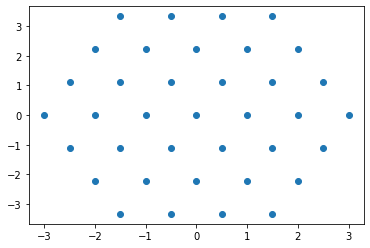

Text(0.5, 1.0, 'triplot of Delaunay triangulation')

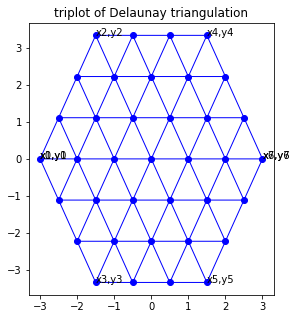

In [108]:
n = 3 #order of the hexagonal domain
HD = rt.HexagonalDomain(n)
x,y = HD.x, HD.y

np.random.seed(seed=4)
n_dist = np.random.normal(loc=0,scale = np.sqrt(rtc.sigma),size = x.shape[0])
HD.get_nodes(n_dist) # will add the attributes n_dist and nodes_dict to class
triang = mpl.tri.Triangulation(x, y) ## Triangulate parameter space to determine the triangles using a Delaunay triangulation

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.set_aspect('equal')
ax1.triplot(triang, 'bo-', lw=1)
for index,c in enumerate(HD.corner_points):
    ax1.annotate('x{},y{}'.format(index,index),xy=(c[0],c[1]))
ax1.set_title('triplot of Delaunay triangulation')

## Initialise incident ray

In [109]:
np.random.seed(1)
p_index = random.randint(0,x.shape[0])
p_h = np.array([x[p_index],y[p_index],0])
r1 = lambda l: np.array([-2,0,0]) + l*rtc.r_1
r2= lambda l: np.array([2,0,0]) + l*rtc.r_2
print(r1(0.7))
print(r2(0.7))
p_h = r2(0.7)
p_prime = p_h + np.array([0,0,np.linalg.norm(p_h)*np.tan(rtc.solar_altitude/180*np.pi)])

t = np.array([-0.5,-2,0]) # target point
xi_prime = t - p_prime
xi_prime = xi_prime/np.linalg.norm(xi_prime)
xi_h = t - p_h
xi_h = xi_h/np.linalg.norm(xi_h)


[-1.71272606  0.63833665  0.        ]
[1.71272606 0.63833665 0.        ]


In [110]:
# initialise raytracing class
RT = rt.RayTracing(p_prime,xi_prime,HD)

In [111]:
print('projected point on the boundary of hexagonal domain where light enters" {}'.format(RT.p_h))
print('point on the boundary of hexagonal domain where light enters" {}'.format(RT.p_prime))
print('vector of xi_prime: {}'.format(RT.xi_prime)) # projection of xi onto the hexagonal plane
print('unit vector of projected xi_prime: xi_h: {}'.format(RT.xi_h)) # projection of xi onto the hexagonal plane
print('Hexagonal Domain:{}'.format(RT.HD))

projected point on the boundary of hexagonal domain where light enters" [1.71272606 0.63833665 0.        ]
point on the boundary of hexagonal domain where light enters" [1.71272606 0.63833665 5.02187786]
vector of xi_prime: [-0.36339575 -0.43329373 -0.82474243]
unit vector of projected xi_prime: xi_h: [-0.64259991 -0.7662019   0.        ]
Hexagonal Domain:<ray_tracing_utils.HexagonalDomain object at 0x000001AA4F3C8278>


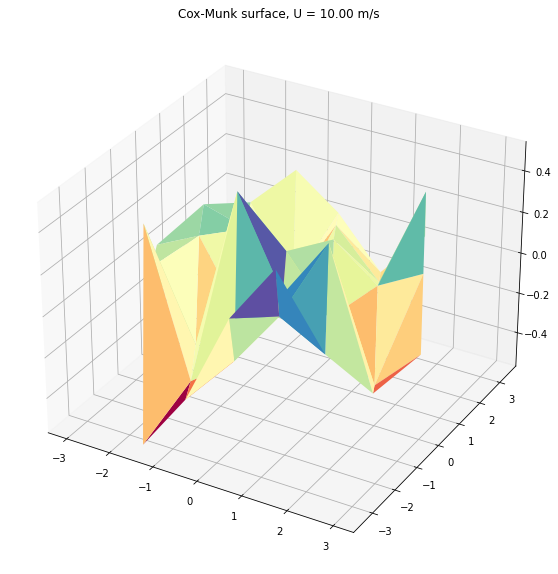

In [112]:
# Plot the surface.  The triangles in parameter space determine which x, y, z points are connected by an edge.
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
# ax = Axes3D(ax)
ax.plot_trisurf(triang,n_dist, linewidth=0.2, antialiased=True,cmap=plt.cm.Spectral) #3d surface
ax.set_title("Cox-Munk surface, U = {:.2f} m/s".format(rtc.U))
plt.show()

# Ray Tracing

- In general, each encounter of a ray with a wave facet generates both reflected and a refracted daughter ray
- The directions and radiant powers of these daughter rays are determined by Snell's law and Fresnel's formula (the daughter rays may undergo further encounters with other wave facets)
- In essence, the ray-tracing procedure devolves on repeatedly finding the intersection of a straight line and a triangular plane facet in space

1. intialise wind speed and direction
2. construct a random surface over the hexagonal grid
3. an initial ray incident along the desired direction. The parent ray may approach the surface from the air/water side. The parent ray $\hat{\xi}$ is assigned a radiant power $\Phi ' = 1$, and the point $\overrightarrow{p}'$ where the ray enters the hexagonal domain (e.g. point A). The information ($\hat{\xi}, \Phi ',\overrightarrow{p}'$) is then stored in an array, called the *stack*
4. pull the next triple array $\hat{\xi}, \Phi ',\overrightarrow{p}'$ from the stack then trace the ray to completion
5. Extend the ray from point $\overrightarrow{p}'$ along direction $\hat{\xi}$ until either the ray encounters a surface or leaves the hexagonal grid. The point $\overrightarrow{p}_i$ of interception of the ray and the surface is determined, and daughter rays are produced
6. one daughter ray will be generated at $\overrightarrow{p}_i$ along the reflected direction $\hat{\xi}_r$.
7. One daughter ray will be generated along $\hat{\xi}_t$ iff the ray is not totally internally reflected at $\overrightarrow{p}_i$.
8. the direction of the parent ray $\hat{\xi}$, the normal $\hat{n}$ to the intercepted wave facet, and the daughter ray direction $\hat{\xi}_r$ determine an associated Fresnel factor for reflectance. The Frenel factor is multiplied into the current radiant power $\Phi$ of the parent ray to obtain the power $\Phi_r$ of the reflected daughter ray. The power of the transmitted ray is thus $\Phi_t = \Phi - \Phi_r$. The daughter ray triples are pushed into the stack for further processing.

See Chapter 4 (Light & Water), page 178

It is easier to write down a recursive formula for the radiant power of a newly born daughter ray at each step between the beginning and end of the parent ray's travels.
we know the values ($\hat{\xi}, \Phi ',\overrightarrow{p}'$) of a parent ray. Tracing the ray from $\overrightarrow{p}$ to an interception point $\overrightarrow{p}_i$ along $\hat{\xi}$ yields a calculable distance $d = |\overrightarrow{p} - \overrightarrow{p}_i|$. The outward normal $\hat{n}_i$ we can decide whether the path of the ray was in air or in water by finding whether $\hat{\xi} \cdot \hat{n}_i < 0$ (air-incident case) or $\hat{\xi} \cdot \hat{n}_i > 0$ (water-incident case)
In the case of total internal reflection, $r(\hat{\xi} \cdot \hat{n}_i) = 1$, and there is no refracted ray

Let $\Phi(I)$ be the downward incident radiant power over patch I of the upper h.m.s of a realisation $S(\omega)$ of the random water surface. This $\Phi(I)$ is produced by the ray of radiance ($L(\hat{\xi '})$) about direction $\hat{\xi '}$

$\Delta \Omega = $ solid angle

$\Delta A$ = area of the ray normal to $\hat{\xi '}$ (area where the incident ray hits)

$\Phi(I) = L(\hat{\xi '}) \Delta \Omega \Delta A$

The upward emergent power $\Phi (R;\omega) = \Phi(I) r_+(\hat{\xi '};\omega) = L(\hat{\xi '}) \Delta \Omega \Delta A  r_+(\hat{\xi '};\omega)$

Most simulations were performed for collimated incident radiance distributions ($L(\hat{\xi '})$) i.e. for all $\hat{\xi '}$ exactly the same, which corresponds to an infinitely distant, point sun in a black sky

The incident ray direction $\hat{\xi '}$ is specified by ($\theta_s ', \phi_s '$), where $\theta_s '$ is the polar angle of the light *source* measured from either the zenith or the nadir direction.

A source located in the downwind direction has $\phi_s ' = 0$

Section 7 of Preisendorfer & Mobley (1985) presents a model-generated glitter pattern for both reflected and transmitted rays starting from both above and below the water surface

### Observations

- incident rays from the zenith (nadir) on a flat air-water surface, 98% of the beam's radiant flux penetrates into the sea below
- Beam incident at 80 degrees from the zenith has only 65% penetration
A wind-ruffled surface allows more transmission of light into sea, compared to a flat calm surface
- First-order-ray-tracing theory is no longer statistically acceptable because the rays are likely to undergo multiple scatering among the wave facets. It also doesnt take into account of the shielding effect of one wave facet blocking rays from another.
- Due to the effect of multiple scattering of light rays, the net penetration of light into the sea decreases, since there are more opportunities for the sea surface to reflect the light back into the sky. However, the shielding of a wave facet increases the light penetration because of increased interception. The net effect of multiple scattering and shielding increases sea surface radiance reflectance for wind speeds
- Normals to the capillary wave facets in the alongwind vertical plane tend on average to be tipped away from the vertical at greater angles than those in the crowsswind vertical plane
- Hence light rays incident, at a fixed zenith angle, on the rippled sea surface in the alongwind plane on average undergo a greater transmission in the sea compared to those incident in the crosswind plane
- Ergodic equivalence of time-averaged wave slop statistics and space-averaged wave slope statistics

# Coordinate system notations

- $\overrightarrow{i}$ downwind
- $\overrightarrow{k}$ perpendicular to mean sea level, and positive upward
- and $\overrightarrow{j} = k \times i$ in the crosswind direction
 
## Ray-tracing in the wind-based system

- An arbitrary vector $u$ in space within the hexagonal domain is:
$$\overrightarrow{u} = u_1\overrightarrow{i} +  u_2\overrightarrow{j} + u_3\overrightarrow{k} = (u_1,u_2,u_3)$$

- Specifying directions of rays, surface normals, we will use unit vectors ($\hat{u}$)
- $\hat{u}$, are also defined in terms of zenith angle ($\theta = \arctan(\hat{u} \cdot k) = \arctan(u_3)$), 
- and an azimuth angle $\phi = \arctan (u_2/u_1)$ (subtended by $i$ axis and $j$ axis, in an anti-clockwise from $i$ axis to $j$ axis)
$$ \hat{u} = (\sin \theta \cos \phi, \sin \theta \sin \phi, \cos \theta) , 0^o \leq \theta \leq 180^o , 0^o \leq \phi \leq 360^o$$

- Use the above unit vectors for ray directions $\overrightarrow{\xi} = (\xi_1,\xi_2,\xi_3) = (\sin \theta \cos \phi, \sin \theta \sin \phi, \cos \theta)$ (directions in which the photons are travelling *to*)
- But sometimes we want to refer to the location from where the photons are coming *from*
- If the sun is located at $(\theta_s, \phi_s)$, then the associated rays with photons travelling from the source have angles $\theta = 180^o - \theta_s$ and $\phi = 180^o + \phi_s$ (modulo $360^o$)
- The assocuated ray $\overrightarrow{\xi}$ thus have photons $90^o \leq \theta \leq 180^o$, so that $\xi_3 = \cos \theta$ is negative (because the ray is heading downwards, whereas upward is defined as the direction of $\overrightarrow{k}$)

![Coord system](images/coord_system.png "Downwind based Coordinate system")

# Hexagonal grid vector directions

The lines forming the sides of the triads have unit vector directions:
$$ \overrightarrow{r_1} = (r_{11},r_{21},0) = r_{11}i + r_{21}j$$

where $r_{11} = \delta/2\gamma$ and $r_{21} = \epsilon/\gamma$

$r_1 = (\delta, 2\epsilon,0)/\| r_1 \| = (\delta, 2\epsilon,0)/(2\gamma) = (\delta/2\gamma,\epsilon/\gamma,0)$


$$ \overrightarrow{r_2} = (r_{12},r_{22},0) = r_{12}i + r_{22}j$$

where $r_{12} = -\delta/2\gamma = -r_{11}$ and $r_{22} = \epsilon/\gamma = r_{21}$, and $\gamma = [(\delta/2)^2 + \epsilon^2]^{1/2}$

$\overrightarrow{\hat{r_k}} = (-r_{2k},r_{1k},0)$, $k=1$ or $2$

where $\overrightarrow{\hat{r_k}}$ is a vector orthogonal to $\overrightarrow{r_k}$, i.e. $\overrightarrow{\hat{r_k}} \cdot \overrightarrow{r_k} = 0$


![hexagonal coord system](images/hex_coord_system.png "hexagonal coord system or order n=2")

A hexagonal grid or order $n$ has $3n(n+1) + 1$ triad nodes (i.e. vertices of the triangles)

These nodes are located at $\pm b\delta i + c\epsilon j$ when $c$ is even, for $b = 0,1,...,n - c/2$;

and at $\pm(b + 1/2)\delta i + c\epsilon j$ when $c$ is odd, for $b = 0,1,...,n - (c+1)/2$

The "i family" of horizontal lines is a family of lines, each of which is a set of points of the form: $ \lambda_0 i + c\epsilon j$ for some fixed $c = 0, \pm1,...\pm n$. $c = 0$ is for the horizontal line through the origin, $c=n$ is for the line forming the top boundary of the hexagon; and $c=-n$ is for the line along the lower boundary.

The "$r_1$ family" of lines is given by: $\lambda_1 r_1 + 2c\epsilon j$

and the "$r_2$ family" of lines is given by: $\lambda_2 r_2 + 2c\epsilon j$ (A factor of 2 is needed for $j$ coordinate because the $j$ nodes are spaced every 2 vertical nodes)

for some fixed $c = 0,\pm 1 ..., \pm n$

## Ray track

- A ray track is the projection of a ray (in 3d space) onto the two-d hexagonal grid.
- The points where a ray track crosses or touches the edges of the triads are called triad intercept points (TIPs), and they are labelled as $y0, y_1, y_2 ..., y_i$
- If a ray track crosses a triad, there are usually two TIPs, and we can specify which edges of the triad have the TIPs
- The triad I in the figure above is of "$ir_2$" because $y_1$ lies on an edge which is a member of the i family of lines, and the other TIP, $y_0$ lies on the edge which is a member of the $r_2$ family. 
- Similarly, triad II is of the type "$r_1 r_2$" and triad III is an example of type "$ir_1$"


## Interactions between a ray and the wave facet

1. Determine where the ray first enters the hexagonal domain (e.g. A), or in the case of a daughter ray, we must determine where the ray leaves the hexagonal domain (e.g. D, E, G)
2. Where the ray intercepts a wave facet (C and F)

### Determination of the initial ray point
- A ray is defined by an initial point $p$ and a direction $\xi$. An initial point $p = (p_1,p_2,p_3)$ can be either on the boundary of the hexagonal domain (e.g. A) or in the interior of the domain (e.g. daughter ray emanating from the water surface, as at B). During initialising of a new ray, select a target point $t$ generally near the center of the hexagonal grid toward which the ray $\xi'$ is directed. Therefore, for a given initial direction $\xi '$, before beginning the ray tracing, we must locate the initial point $p'$ where the incoming ray $\xi'$ enters the hexagonal domain on its way to $t$.
- Use a prime to distinguish an "incoming" ray e.g. at $p'$ along $\xi'$, absence of a prime indicates a reflected or transmitted daughter ray
- The ray track $\xi'$ is the straight line containing points of the form $t + s\xi_h'$, where $\xi_h' = (\cos\phi, \sin\phi,0)$ is a unit vector determined from the projection of $\xi'$ onto the hexagonal grid, and $s$ represents distance traveled in the grid away from point $p_h'$, the projection of $p'$
- In general a ray track $t + s\xi_h'$ intersects the $i$ family of lines in a set of points whose distances $s$ from $t$ can be found by setting $t + s\xi_h = \lambda_0i + c\epsilon j$ and solving for $s$. Taking the dot product with $j$ gives $t \cdot j + s \xi_h \cdot j = c\epsilon$,

so that the $s$ values are given by

$s_0(c,t,\xi_h) = (c\epsilon - t \cdot j)/(\xi_h \cdot j)$

with $c = 0, \pm 1,...\pm n$ and $\xi_h \cdot j \neq 0$

Likely, the intersections of the track with the $r_1$ and $r_2$ families of lines are found by setting:

$t s\xi_h = \lambda_k r_k + 2c\epsilon j$, $k=1,2$, and taking the dot product with $\hat{r_k}$

$s_k(c,t,\xi_h) = ((2c\epsilon j \cdot \hat{r_k} - t \cdot \hat{r_k})/(\xi_h \cdot \hat{r_k}))$ for $k = 1,2$, $c = 0, \pm 1,..., \pm n$ and $\xi_h \cdot r_k \neq 0$

The $s_k$ are the distances from $t$ at which the track crosses the $r_k$ families of lines.

- If a ray started from $t$ in a direction $-\xi_h'$, then its track crosses the boundary lines of the $r_k$ family ($k = 1,2$), or $i$ family ($k=0$) at $s_k(\pm n, t, -\xi_h')$

![ray track](images/ray_track.png "ray track")

Then the initial point $p'$ at which the ray $\xi'$ enters the hexagonal domain on its way to $t$ is given by:
$$p' = t - \left [ \frac{s_{min}(t,-\xi_h')}{\xi' \cdot \xi_h'} \right ]\xi'$$
$\xi' \cdot \xi_h' \neq 0$, and $s_{min}(t,-\xi_h') = $ minimum of the positive values of {$s_k(\pm n, t, -\xi_h'): k = 0,1,2$

### Determination of the triad interception points (TIPs)
Let $p = (p_1,p_2,p_3)$ be any point in the hexagonal domain or on its boundary, and let $\xi$ be an arbitrary direction at $p$. It is assumed that $p$ and $\xi$ are held fixed. 

The projection of $p$ onto the hexagonal grid is $p_h = (p_1,p_2,0)$, and $\xi_h$ is the unit vector determined as before from the projection of $\xi$. Then $p_h + s\xi_h$, as $s$ varies over all real values, generates the track of the ray.

The distances from $p_h$ to the intercepts of the track with the families of lines defining the triads are given by the equations above (to obtain $s_k$)

For the $i$ family we have:

$s_0(c,p_h,\xi_h) \equiv (c\epsilon - p_h \cdot j)/(\xi_h \cdot j)$

and for the $r_k$ families we have

- $ s_k(c,p_h,\xi_h) \equiv (2c\epsilon j \cdot \hat{r_k} - p_h \cdot \hat{r_k})/(\xi_h \cdot \hat{r_k})$, $k=1,2$, where $c = 0, \pm 1,...,\pm n.$. 

$s_k$ defines the distances (positive along $\xi_h$) from $p_h$ to all possible intersections of the ray track with the lines which define the triad boundaries. However, only those $s_k (c,p_h,\xi_h)$ values between 0 and $s_{min}(p_h,\xi_h)$ are within the hexagon. 

- $s_{min}(p_h,\xi_h) = $ minimum of the positive values of $ s_k(\pm n,p_h,\xi_h): k = 0,1,2$

e.g. For track AE, the TIP $y_0$ is at a distance $s_2(2,p_h,\xi_h) = 0$ from A (i.e. the first TIP is $y_0 = p_h$). 

TIP $y_1$ is at a distance $s_0(1,p_h, \xi_h)$ from A, and so on until $y_8$ at E is reached at a distance $s_{min}(p_h,\xi_h) = s_2(-2,p,\xi_h)$ from A.

Note that as we proceed from $p_h$ to the boundary of the hexagon, the $s_k(c,p_h,\xi_h)$ values can occur in any order of $k = 0,1,2$ in the TPS sequence ($y_j, j = 0,1,...,n$). e.g. $y_0$ has an $s$ value from the $k=2$ family, $y_1$ with $k=0$, $y_2$ with $k=2$, $y_3$ with $k=1$. It is necessary to know which $k$ family is associated to which distances $s_k(c,p_h,\xi_h)$.

- Let $s(j)$ denote the $s_k(c,p_h,\xi_h)$ associated with TIP $y_j$
- Let $k(j)$ denote the $k$ family of $s(j)$
- Thus, the TIPs are given by : $y_j = p_h + s(j)\xi_h$, for $j = 0, 1,...,n$

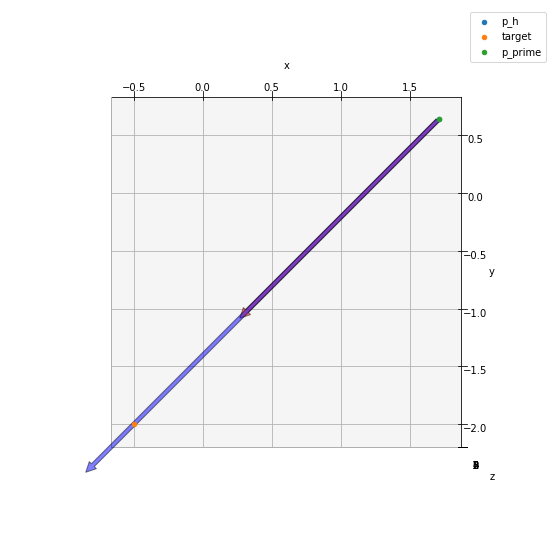

In [113]:
sf = 4 #scaling factor
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_proj_type('ortho')
ax.view_init(elev=90, azim=-90)
ax.scatter(p_h[0],p_h[1],p_h[2],label='p_h')
ax.scatter(t[0],t[1],t[2],label='target')
ax.scatter(p_prime[0],p_prime[1],p_prime[2],label='p_prime')
ax.arrow3D(p_prime[0],p_prime[1],p_prime[2],
            dx = sf*xi_prime[0], dy = sf*xi_prime[1],dz = sf*xi_prime[2],
            mutation_scale=20,fc = 'red',alpha=0.5)
ax.arrow3D(p_h[0],p_h[1],p_h[2],
            dx = sf*xi_h[0], dy = sf*xi_h[1],dz = sf*xi_h[2],
            mutation_scale=20,fc = 'blue',alpha=0.5)
plt.legend()
plt.show()

In [114]:
ordered_TIPs = RT.get_TIPs()
ordered_TIPs

{0: [5.183241607669338, 3.7332004316154, 2.2831592555614626, 0.833118079507525, -0.6169230965464125, -2.0669642726003503, -3.517005448654288], 1: [-5.287583668220747, -1.9294236878890538, 1.42873629244264, 4.786896272774334, 8.145056253106029, 11.503216233437723, 14.861376213769415], 2: [5.063713111077348, 4.0509704888618785, 3.0382278666464084, 2.0254852444309392, 1.0127426222154696, 0.0, -1.0127426222154694]}


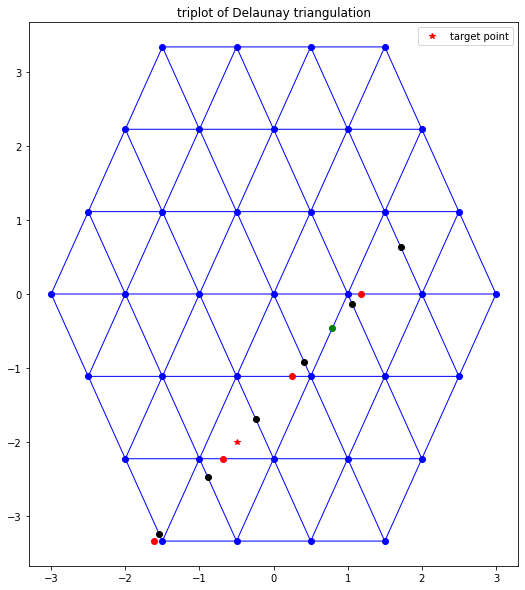

In [115]:
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.set_aspect('equal')
ax1.triplot(triang, 'bo-', lw=1)
# ax1.plot([t[0] for t in TIPs],[t[1] for t in TIPs],'o')
c = {0:'r',1:'g',2:'k'}
for i in ordered_TIPs:
    ax1.plot(i.coord[0],i.coord[1] ,f'{c[i.k]}o')
ax1.plot(t[0],t[1],'r*',label="target point")
ax1.set_title('triplot of Delaunay triangulation')
plt.legend()
plt.show()

In practice, the TIPs are found by the following steps:
1. generating all possible $s_k(c,p_h,\xi_h)$ values
2. finding $s_{min}(p_h,\xi_h)$
3. recording all $s_k$-distances, as $c$ varies, such that $0 \leq s_k(c,p_h,\xi_h) \leq s_{min}(p_h,\xi)$ holds
4. ordering the values of step 3 from smallest to largest
5. relabelling these ordered values as $s(j)$, with $j=0$ for the smallest value of step 4, e.g. $s_k(c,p_h, \xi_h) \equiv s(0)$ to $j=m$ for the largest value $s_{min}(p_h, \xi_h) \equiv s(m)$
6. Recording the $k$ values associated with each $j$ value of step 5 according to the $k(j)$ notation
7. generating the ordered TIP values $y_j$

### Determination of the triad vertices
- How to recover the locations of the triad vertices from the TIPs. 
- Identify those facets which are candidates for interaction with the ray, since triads are uniquely determined by the coordinates of their vertices

In the case of TIP ($y_k$) lies on a line of the $r_k$ family, $k=1,2$:
$y_k = p_h + s(k)\xi_h = \lambda_k r_k + d_k j$ ($r_1 r_2$ case)

![determination of vertices](images/determine_triad_vertices.png "determination of vertices")
Geometric relations for determination of the triad vertices $a,b$ and $c$ from triad intercept points $y_1$ and $y_2$ which are of type $r_1 r_2$

#### $r_1 r_2$ case

Check if it's of $r_1 r_2$ case: Given a pair of TIPs $y_{j_1} \equiv y_1, y_{j_2} \equiv y_2$

The notation $y_1$ and $y_2$ is used only for convenience to label which TIP lies on which side ($r_k$) of the triad

$k(y_{j_1}) + k(y_{j_2}) = 3$ (sum of the associated $k$ of the TIPs)

Taking the dot product with $\hat{r_k}$ yields $d_k$

$ d_k = [p_h + s(k)\xi_h] \cdot \hat{r_k}/j \cdot \hat{r_k} = (\hat{y_k} \cdot \hat{r_k})/(j \cdot \hat{r_k}), \quad k = 1,2 \quad$ ($ r_1 r_2$ case)

Since $a$ lies on the $r_k$ line, we have for some $\lambda_k \equiv \lambda (a)$,

$\lambda_k(a)  r_k + d_k j = a, \quad k=1,2$

$ \lambda_k(a) = (a - d_k j) \cdot r_k, \quad k=1,2$

Since $y_k$ lies on the $r_k$ line, we have for some $\lambda_k \equiv \lambda (k)$,

$ \lambda_k = (y_k - d_k j) \cdot r_k, \quad k=1,2$

Note that $d_k, \lambda_k$ and $\lambda_k (a)$ can be positive or negative, depending on the location of the triad in the hexagonal grid.

$\frac{h}{0.5(d_2 - d_1)} = \frac{0.5 \delta}{\epsilon}$ (based on similar triangles)

$h = (d_2 - d_1) \delta/4 \epsilon$

We can now write vertex $a$ in terms of quantities computed from TIPs ($r_1 r_2$ case)

$$a = h i + 0.5(d_1 + d_2)j \equiv (a_1,a_2,0)$$

Defining

$sign[x] \equiv \begin{cases}
+1 \quad \text{if} \quad x>0 \\
-1 \quad \text{if} \quad x<0
\end{cases}$

We can now write vertex $b$ and $c$ as 

$b = a + sign[\lambda_1 - \lambda_1 (a)] \gamma r_1$

Sub in $a$ and $r_1$, 

$$b = (a_1 + sign[\lambda_1 - \lambda_1(a)]\frac{\delta}{2})i + (a_2 + sign[\lambda_1 - \lambda_1(a)]\epsilon)j$$

$c = a + sign[\lambda_2 - \lambda_2 (a)] \gamma r_2$

Sub in $a$ and $r_2$, 

$$c = (a_1 - sign[\lambda_2 - \lambda_2(a)]\frac{\delta}{2})i + (a_2 + sign[\lambda_2 - \lambda_2(a)]\epsilon)j$$

These equations hold for both possible triad orientation (e.g. inverted, left of the origin, where h is negative)

#### $ir_1$ case

$k(y_{j_1}) + k(y_{j_2}) = 1$ (sum of the associated $k$ of the TIPs)

If $y_0$ lies on an $i$ line,

$y_0 = p_h + s(0)\xi_h = \lambda_0 i + d_0 j$

$d_0 = y_0 \cdot j$

since $a$ also lies on an $i$ line:

$a = \lambda_0 (a)i + d j$

$\lambda_0 (a) = a \cdot i$

$ \lambda_0 = y_0 \cdot i$ (If $y_0$ lies on an $i$ line)

If $y_1$ lies on an $r_1$ line, we have $d_1, \lambda_1(a), \lambda$ as above

Similar triangles give $\frac{h}{d_0 - d_1} = \frac{0.5 \delta}{\epsilon}$ or

$h = (d_0 - d_1)\delta/(2 \epsilon)$

Therefore, the triad vertices are given by (for $ir_1$ case):

$$a = h i + d_0 j \equiv (a_1,a_2,0)$$

$$b = a + sign[\lambda_1 - \lambda_1(a)] \gamma r_1 \\
= (a_1 + sign[\lambda_1 - \lambda_1(a)] \frac{\delta}{2} )i + (a_2 + sign[\lambda_1 - \lambda_1(a)] \epsilon) j$$

$$ c = a + sign[\lambda_0 - \lambda_0(a)] \delta i \\
= (a_1 + sign[\lambda_0 - \lambda_0(a)] \delta)i + a_2 j$$


#### $ir_2$ case

$k(y_{j_0}) + k(y_{j_2}) = 2$ (sum of the associated $k$ of the TIPs)

$h = (d_2 - d_0)\delta/(2 \epsilon)$

Therefore, the triad vertices are given by (for $ir_1$ case):

$$a = h i + d_0 j \equiv (a_1,a_2,0)$$

$$b = a + sign[\lambda_2 - \lambda_2(a)] \gamma r_2 \\
= (a_1 - sign[\lambda_2 - \lambda_2(a)] \frac{\delta}{2} )i + (a_2 + sign[\lambda_2 - \lambda_2(a)] \epsilon) j$$

$$ c = a + sign[\lambda_0 - \lambda_0(a)] \delta i \\
= (a_1 + sign[\lambda_0 - \lambda_0(a)] \delta)i + a_2 j$$


![determination of vertices](images/determine_triad_vertices1.png "determination of vertices")

In [48]:
intersect_vertices_list = []
for i in range(1,len(ordered_TIPs)):
    v = RT.TIP_vertices(ordered_TIPs[i],ordered_TIPs[i-1])
    intersect_vertices_list.append(v)

intersect_vertices_list

[(array([2., 0., 0.]),
  array([1.5      , 1.1110243, 0.       ]),
  array([1., 0., 0.])),
 (array([1., 0., 0.]),
  array([ 1.5      , -1.1110243,  0.       ]),
  array([2., 0., 0.])),
 (array([1., 0., 0.]),
  array([ 0.5      , -1.1110243,  0.       ]),
  array([ 1.5      , -1.1110243,  0.       ])),
 (array([ 0.5      , -1.1110243,  0.       ]),
  array([1., 0., 0.]),
  array([0., 0., 0.])),
 (array([ 0.5      , -1.1110243,  0.       ]),
  array([0., 0., 0.]),
  array([-0.5      , -1.1110243,  0.       ])),
 (array([-0.5      , -1.1110243,  0.       ]),
  array([ 3.88578059e-16, -2.22204860e+00,  0.00000000e+00]),
  array([ 0.5      , -1.1110243,  0.       ])),
 (array([ 3.99711518e-16, -2.22204860e+00,  0.00000000e+00]),
  array([-0.5      , -1.1110243,  0.       ]),
  array([-1.       , -2.2220486,  0.       ])),
 (array([-1.       , -2.2220486,  0.       ]),
  array([-0.5       , -3.33307291,  0.        ]),
  array([ 0.       , -2.2220486,  0.       ])),
 (array([ 1.        , -6.6

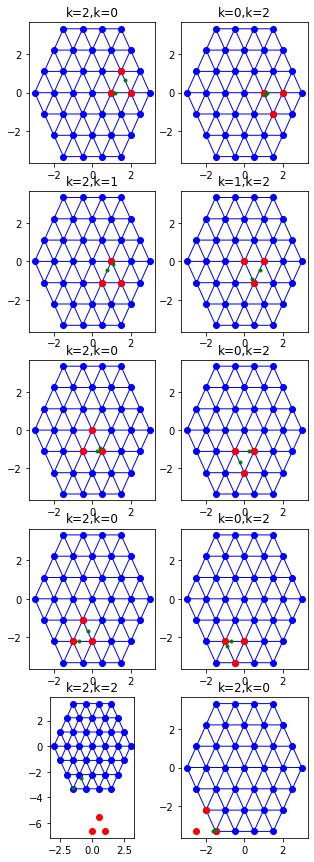

In [49]:
fig, axes = plt.subplots(ceil(len(intersect_vertices_list)/2),2, figsize=(5,15))
for i,(v, ax) in enumerate(zip(intersect_vertices_list,axes.flatten())):
    coord = ordered_TIPs[i:i+2]
    ax.set_aspect('equal')
    ax.triplot(triang, 'bo-', lw=1)
    # ax1.plot([t[0] for t in TIPs],[t[1] for t in TIPs],'o')
    ax.plot([t[0] for t in v],[t[1] for t in v],'ro')
    ax.plot([c.coord[0] for c in coord],[c.coord[1] for c in coord],'g.')
    ax.set_title(f'k={coord[0].k},k={coord[1].k}')
plt.show()

### Determination of the facet intersection point

- Elevations of the random sea surface are defined at the triad vertices.
- Given the triad vertices $a,b,c$, we can immediately obtain the vertices $v_1,v_2,v_3$ (in 3-space) of the associated wave facet:

$v_1 = a + z_a k$

$v_2 = b + z_b k$

$v_3 = c + z_c k$

$z_a, z_b, z_c$ are the random elevations of the sea surface at nodes $a,b, c$ (determined earlier), and $k = (0,0,1)$ is the unit vector normal to the mean sea surface

Let $F(v_1,v_2,v_3)$ denote the wave facet, then a unit normal to this facet is:

$$n_1 \equiv \frac{(v_3 - v_1) \times (v_2 - v_1)}{\parallel (v_3 - v_1) \times (v_2 - v_1)\parallel} $$

The unit outward normal $n$ to the facet $F(v_1,v_2,v_3)$ is such that $n \cdot k > 0$ and is obtained from

$n = sign[n_1 \cdot k]n_1$

A point $q$ lying on the wave facet and lies on the ray has to meet the conditions:

$(q - v) \cdot n = 0$, where $v$ is a vector lying on the plane, and $n$ is a surface normal of a facet

$q = p + s(q)\xi$,

where $s(q)$ is the distance along the ray from $p$ to $q$ in the plane. We can solve for $s(q)$ from

$$(q - v_1) \cdot n = (p + s(q)\xi - v_1) \cdot n = 0$$

whence

$$ s(q) = ((v_1 - p) \cdot n)/(\xi \cdot n) $$

where $v_1$ is the chosen node that lies on the facet $F(v_1,v_2,v_3)$. Point $q$ in particular lies in the subset of the plane bounded by the facet itself iff:

$s(j_i) < s(q)\xi \cdot \xi_h < s(j_{i+1})$

where $j_i$ and $j_{i+1}$ are the pair of adjacent TIPs associated with the wave facet $\in$ ordered_TIPs (i.e. iterate across the TIPs and checking systematically whether $s(q)\xi \cdot \xi_h$ lies within the bounds)

Either the ray will intercept one of the facets at a point $q$ or ray leaves the hexagonal domain without striking the sea surface


In [50]:
facets = RT.get_normal_facet(intersect_vertices_list) #list of projected facets where TIPs lie on
intercepted_facets = RT.get_intercepted_facets(facets,ordered_TIPs)

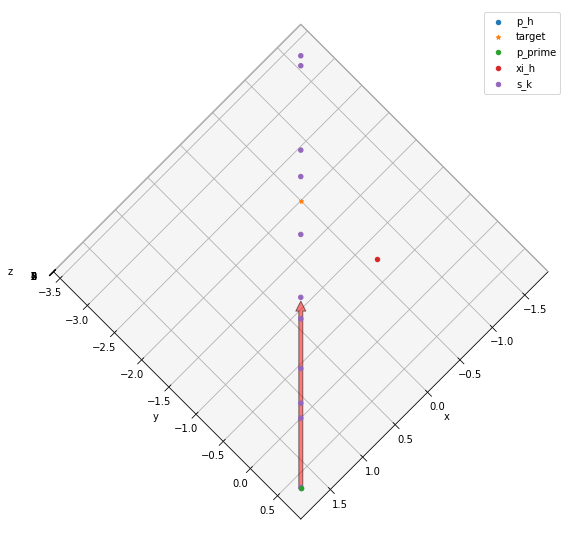

In [51]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_proj_type('ortho')
ax.view_init(elev=90, azim=45)
ax.arrow3D(p_prime[0],p_prime[1],p_prime[2],
    dx = sf*xi_prime[0],dy = sf*xi_prime[1],dz = sf*xi_prime[2],
    mutation_scale=20,fc = 'red',alpha=0.5) #unit vector of xi_prime * scaling_factor
ax.scatter(p_h[0],p_h[1],p_h[2],label='p_h')
ax.scatter(t[0],t[1],t[2],marker="*",label='target')
ax.scatter(p_prime[0],p_prime[1],p_prime[2],label='p_prime')
ax.scatter(xi_h[0],xi_h[1],xi_h[2],label='xi_h')

ax.scatter([t.coord[0] for t in ordered_TIPs],[t.coord[1] for t in ordered_TIPs],0,'k.', label="s_k")
plt.legend()
plt.show()

No handles with labels found to put in legend.


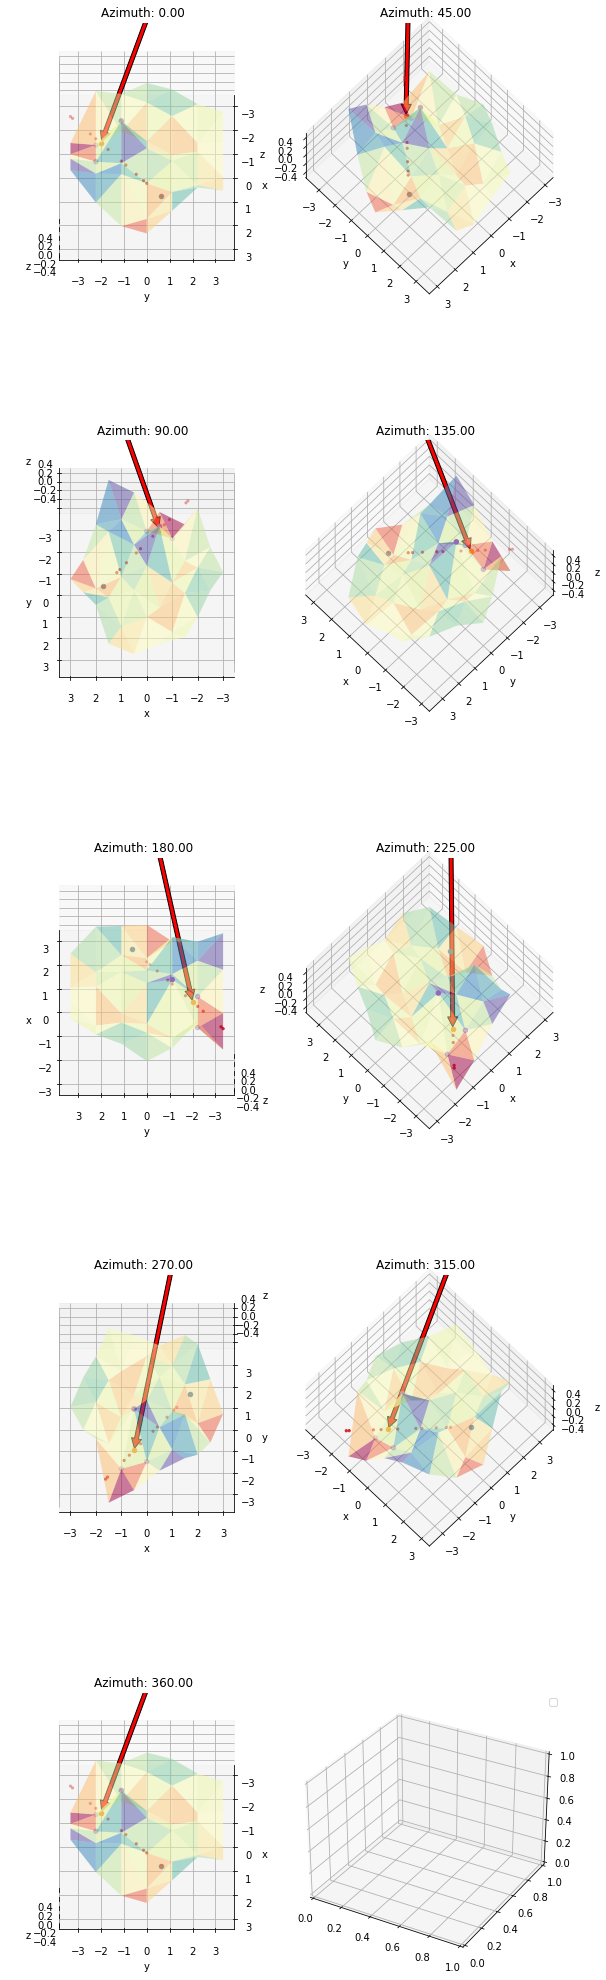

In [52]:
views = [(rtc.solar_altitude ,i) for i in np.arange(0,360+45,step=45)]
fig, axes = plt.subplots(ceil(len(views)/2),2,subplot_kw={'projection': '3d'},figsize=(8,30))
for angles,ax in zip(views, axes.flatten()):
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_zlim(-0.5,0.5)
    ax.set_proj_type('ortho')
    ax.view_init(elev=angles[0], azim=angles[1])
    ax.set_title('Azimuth: {:.2f}'.format(angles[1]))
    ax.plot_trisurf(triang,n_dist, linewidth=0.2, antialiased=True,cmap=plt.cm.Spectral,alpha=0.5) #3d surface
    ax.scatter(p_h[0],p_h[1],p_h[2],label='p_h')
    ax.scatter(t[0],t[1],t[2],label='target')
    ax.scatter(p_prime[0],p_prime[1],p_prime[2],label='p_prime')
    # ax.scatter([t.coord[0] for t in ordered_TIPs],[t.coord[1] for t in ordered_TIPs],zs=0,label="s_k",c='k')
    ax.arrow3D(p_prime[0],p_prime[1],p_prime[2],
        dx = t[0] - p_prime[0],
        dy = t[1] - p_prime[1],
        dz = t[2] - p_prime[2],mutation_scale=20,fc = 'red')
    ax.scatter([t.coord[0] for t in ordered_TIPs],[t.coord[1] for t in ordered_TIPs],0,marker=".", label="s_k")
    for v in intercepted_facets:
        ax.scatter([i[0] for i in v.nodes],[i[1] for i in v.nodes],[i[2] for i in v.nodes],'ro',label="intercepted facet")

plt.tight_layout()
plt.legend()
plt.show()

### Determination of reflected and transmitted rays

Suppose that a ray $\xi'$ intercepts at point $q$, a wave facet whose outward normal is $n$. Let $N'$ be the radiance of the incident ray. This ray generally gives rise to two daughter rays at $q$. Suppose that the reflected daughter ray along $xi_r$ has radiance $N_r$ and the refracted daughter ray along $\xi_t$ has radiance $N_t$.

To calculate $\xi_r,\xi_t$ and $N_r, N_t$, it is necessary to distinguish the cases where $xi'$ at $q$ is air- or water-incident (i.e. where $\xi'$ arrives at $q$ via air or water)

- In the air-incident case: $\xi' \cdot n < 0$
- In the water-incident case: $\xi' \cdot n > 0$
*Note*: $n$ is defined as above w.r.t upward direction $k$

![air-water incident case](images/air-water%20incident.png "reflected and refracted rays")

Schematic diagrams for reflected and refracted rays. The diagrams are based on Snell's law of refraction and the law of reflection of rays.

- $m_a$: index of refraction of air
- $m_w$: index of refraction of water
- $\theta_a$: acute angles between $n$ and the ray direction $\xi_a$
- $\theta_w$: acute angles between $n$ and the ray direction $\xi_w$

Snell's law states (which holds regardless of the direction of approach of a ray to the air-water surface):

$$m_a \sin \theta_a = m_w \sin \theta_w$$

#### Air-incident case

In the air-incident case: 
- $\theta' = \theta_a$
- $\theta_t = \theta_w$
- $\theta_r = \theta'$
- $m_a = 1$
- $m = m_w = 4/3$

Given an incident direction $\xi'$, we have the following working formulas from the above diagram:

$\xi_r \equiv \xi' - 2(\xi' \cdot n)n$

$\xi_t \equiv (\xi' - cn)/m \quad; c= n \cdot \xi' - [(\xi' \cdot n)^2 + m^2 -1]^{0.5}$

$\theta' \equiv \arccos|\xi' \cdot n| = \theta_r$

$\theta_t \equiv \arcsin[m^{-1} \sin \theta']$

#### Water-incident case

- $\theta' = \theta_w$
- $\theta_t = \theta_a$
- $\theta_r = \theta'$
- $m_a = 1$
- $m = m_w = 4/3$

$\xi_r \equiv \xi' - 2(\xi' \cdot n)n$

$\xi_t \equiv m\xi' - cn \quad; c= m \xi' \cdot n - [(m \xi' \cdot n)^2 - m^2 +1]^{0.5}$

$\theta' \equiv \arccos|\xi' \cdot n| = \theta_r$

$\theta_t \equiv \arcsin[m \sin \theta']$

The constant $c$ is fixed in each case by requiring $\xi_t$ to be a unit vector, given the unit vectors $\xi'$ and $n$, and such that $c$ approaches 0 as $m$ approaches 1.

### Fresnel reflectance formula

For either the air- or water-incident case, the reflectance $r(\theta')$ of the air-water surface for unpolarised incident radiant flux is given by

$$ r(\theta') \equiv r(\xi' \cdot n) \equiv 0.5 \left\{ \left[ \frac{\sin{\theta' - \theta_t}}{\sin(\theta'+\theta_t)} \right]^2 + \left[\frac{\tan{\theta' - \theta_t}}{\tan{\theta' + \theta_t}} \right]^2 \right\}$$

### Irradiance versus Radiance

- Radiance is the unit that conveys the amount of radiant flux emitted, transmitted, or reflected by a surface. The radiance unit is determined as the unit power per solid angle per unit projected area.
- In contrast to radiance measurements, irradiance is the radiant flux received by a surface or the flux that is incident on the surface. The irradiance unit is determined as power per unit area.
- A spectral radiance measurement expresses radiance as a function of wavelength or frequency.

### Radiant Flux conservation

The reflectance for unpolarised *irradiance* $H \text{watt}/m^2$ between 2 dielectric media of indexes of refraction $m_a$ and $m_w$ with $\theta_t$ are shown above. 

If $H'$ is the incident *irradiance* ($\text{watt}/m^2$, in air or water) and $H_r$ and $H_t$ are the reflected and transmitted *irradiances* at the interface, then

$$H_r \equiv H' r(\xi' \cdot n)$$

$$H_t \equiv H' t(\xi' \cdot n)$$

where $t(\xi' \cdot n) \equiv 1 - r(\xi' \cdot n)$

Radiant flux conservation holds:

$$H' = H_r + H_t$$

### Radiance reflectance and transmittance laws

To derive radiance reflectance and transmittance laws, we use the corollary of Snell's law.

$m_a^2 \mu_a \Omega_a = m_w^2 \mu_w \Omega_w$

where $\Omega_a$ and $\Omega_w$ are respectively the small solid angles of two refraction-related pencils of rays on the air and water sides of the air-water surface, and where $\mu_a = |\xi_a \cdot n|$ and $\mu_w = |\xi_w \cdot n|$. This relation is useful for deducing either $\Omega_a$ or $\Omega_w$. It generally expresses the invariance of the optical volume of a packet of photons along a pencil of rays as the packet traverses interfaces of optical media of different indexes of refraction.

The reflection process is easier: $\mu_a = \mu_w$ and $\Omega_a = \Omega_w$ for incident and reflected pencils of rays.

#### Air-incident case

$H_r = H_a r(\xi' \cdot n) = N_a \mu_a \Omega_a r(\xi_a \cdot n)$

$H_t = H_a t(\xi' \cdot n) = N_a \mu_a \Omega_a t(\xi_a \cdot n)$

where $N_a$ and $N_w$ are the radiances of two refraction-related pencils of unpolarised light rays at the air-water interface, and if $\xi_a = \xi'$, $H_a = H'$ and $H_w = H_t$

The radiant flux conservation becomes:

$$ H_a = N_a \mu_a \Omega_a = N_a \mu_a \Omega_a r(\xi_a \cdot n) + N_a \mu_a \Omega_a t(\xi_a \cdot n)$$

Replacing $\mu_a \Omega_a$ using corollary of Snell's law (as above) in the transmission term

$$ N_a \mu_a \Omega_a = N_a \mu_a \Omega_a r(\xi_a \cdot n) + [N_a (\frac{m_w^2}{m_a^2}) t(\xi_a \cdot n)] \mu_w \Omega_w$$

We define the transmitted radiance as $N_w \equiv N_a (\frac{m_w^2}{m_a^2}) t(\xi_a \cdot n)$

#### Water-incident case

Interchanging $a$ and $w$, yields the corresponding radiance transmittance law for the water-incident case:

$N_a \equiv N_w (\frac{m_a^2}{m_w^2}) t(\xi_w \cdot n)$

How radiance is reflected is simply $N_r = N_a r(\xi_a \cdot n)$

#### Summary 
In summary, by setting $m_a = 1, m_w = 4/3$, and writing $\xi'$ for $\xi_a$ or $\xi_w$ (depending on whether it is air- or water-incident), and writing $N$ for $N_a$ or $N_w$, we find that the radiance reflectance and transmittance laws at the air-water interface:

$N_r = N'r(\xi' \cdot n)$ (reflectance; for air- or water-incidence)

$N_t = N'm^2 t(\xi' \cdot n)$ (air-incident case)

$N_t = N'm^{-2} t(\xi' \cdot n)$ (water-incident case)

But we will only focus on the basic laws of reflection and refraction on the irradiance/radiant flux level, rather than radiance

### Example of a simple ray path

A narrow pencil of unpolarised rays of central direction $\xi'$ is incident on $S(\omega)$ at point B. The pencil illuminates a small patch A of outward normal $n$ on $S(\omega)$. To define the reflectance of $S(\omega)$ when the surface is highly crinkled, we place an h.m.s just above $S(\omega)$. We use the h.m.s to register the incident radiant flux $P(I)$ (radiant flux on patch of incident ray) of the pencil on its way to A on $S(\omega)$. 

$P(A) = P(I)$ (conservation of radiant flux)

A fraction $r(\xi' \cdot n)$ of $P(A)$ is reflected into the direction $\xi$ and then streams upward through patch $R$ of the h.m.s. If $P(R)$ is the radiant flux of the reflected pencil crossing $R$, then $P(R) = P(A)r(\xi' \cdot n) = P(I)r(\xi' \cdot n)$

![h.m.s](images/h_m_s.png)

Illustrating the use of the horizontal monitoring surface (h.m.s) for single scattering (upper) and multiple scattering (lower)

The albedo or irradiance reflectance $r_(\xi')$ of $S(\omega)$ relative to this particular pencil is by definition

$r\_(\xi') \equiv P(R)/P(I) = r(\xi' \cdot n)$

The irradiance transmittance $t(\xi')$ of $S(\omega)$ is then

$t\_(\xi') \equiv 1 - r_(\xi')$

### Example of a complex ray patch

An incident pencil of rays of unpolarised radiant flux $P(I)$ crosses the h.m.s and illuminates a small patch $A_1$ with outward normal $n_1$, where a refracted daughter pencil of rays travels along direction $\xi'$ a distance $d$ underwater to encounter patch $A_2$ of outward normal $n_2$, then refracted into a new daughter ray along $\xi_2$. The final encounter of this particular ray bundle is over patch $A_3$ with outward normal $n_3$, from which the flux of a new daughter ray bundle proceeds along $\xi_3$ toward the h.m.s and emerges through patch $R$ carrying radiant flux $P(R)$. The ratio of this emergent flux $P(R)$ to the incident flux $P(I)$ i.e. the albedo of $S(\omega)$ in this path instance is:

$r\_(\xi') = P(R)/P(I) = t(\xi' \cdot n_1) \exp[-\alpha d] t(\xi_1 \cdot n_2) r(\xi_2 \cdot n_3)$

where $t(\xi' \cdot n_1) = 1 - r(\xi' \cdot n_1)$, where $r(\xi' \cdot n_1)$ is from the fresnel reflectance formula

The exponential factor for the underwater path segment of distance $d$, accounts for the flux lost from the daughter bundle, due to absorption and scattering, as the bundle travels from patch $A_1$ to $A_2$. 

$\alpha$ is the volume attenuation coefficient for the water. Setting $\alpha = 0$ in effect makes the water transparent (i.e. no attenuation). Setting $\alpha = \inf$ eliminates any multiple scattering effects from subsurface travels.

### The general recursive ray path

Many daughter paths can spring from a single incident ray approaching $S(\omega)$ along a direction $\xi'$. We can classify these possibilities by counting the number $n_s$ of scattering points and the number $n_b$ of branches into which the original ray splits.

For air-incident rays, the three-branchm single scattering event is the most common at all wind-speeds and angles of incidence. As the wind speed increases, or if incident rays come in nearly horizontal, then the numbers of scatters and branches increases.

For water-incident rays, single scattering events are also most common.

![scattering events](images/scattering%20events.PNG "scattering events")

Common scattering events. Top row is for air-incident case, bottom row is for the water-incident case. $n_s$ counts the number of ray-surface encounters, $n_b$ the total number of parent and daughter rays (branches)

It is more expedient to simply write down a recursive formula for the radiant flux content of a newly born daughter ray at each step between the beginning and end of the parent ray's travels

We know the values of $\xi, p', P'$ defining the parent ray, where $p'$ is the point where $\xi$ enters the hexagonal domain, and $P'$ is the unit radiant flux $=1$

Tracing the ray from $p'$ to an interception point $p_i$ along $\xi$ yields a calculable distance $d = \parallel p' - p_i \parallel$. The outward normal $n_i$ to $S(\omega)$ at $p_i$ is known as above. From $n_i$ we can decide whether the patch of the ray was in air or water by finding whether $\xi \cdot n <0$ (air_incident). The daughter ray directions $\xi_r$ and $\xi_t$ at $p_i$ are then found as above (section 3E)

#### Air-incident case

The generated daughter rays are defined by

$(\xi_r,p_i,P_r)$, with $P_r = P r(\xi \cdot n_i)$, for the reflected ray

$(\xi_t,p_i,P_t)$, with $P_t = P t(\xi \cdot n_i)$, for the refracted ray, where $P$ is modified according to multiplying by $r(\xi \cdot n_i)$ or $t(\xi \cdot n_i) = 1- r(\xi \cdot n_i)$

#### Water-incident case

The daughter rays are defined in a similar way:

$(\xi_r,p_i,P_r)$, with $P_r = P \exp[-\alpha d] r(\xi \cdot n_i)$

$(\xi_t,p_i,P_t)$, with $P_t = P \exp[-\alpha d] t(\xi \cdot n_i)$

To account for flux lost from the ray during water transmission, we include $\exp[-\alpha d]$. In the case of total internal reflection, $r(\xi \cdot n_i) = 1$ so that there is no refracted ray. The daughter ray triples are immediately pushed into the stack for subsequent processing

## Using the result

Let a pencil of rays of radiance $N(\xi')$ be incident on such a surface at each point of its upper h.m.s. Let $\Delta \Omega$ be the small solid angle of the pencil. Then $N(\xi')|\xi' \cdot k| \Delta \Omega$ is the irradiance (watt/$m^2$) incident at each point of the h.m.s of the air-water surface. Further, by construction of $r\_(\xi')$, $N(\xi')|\xi' \cdot k| r\_(\xi') \Delta \Omega$ is the radiant emittance (outward-directed irradiance) of the upper h.m.s and $N(\xi')|\xi' \cdot k| t\_(\xi') \Delta \Omega$ is the radiant emittance of the lower h.m.s of the air-water surface. Since the random air-water surface is on average flat and horizontal, we may, in practice, let the upper and lower h.m.s approach this flat average surface, and coalesce with it. Hence, in practice $r_{\pm}(\xi')$ and $t_{\pm}(\xi')$ may be associated with the mean horizontal surface of a wind roughened sea. 

# Recursive ray-tracing

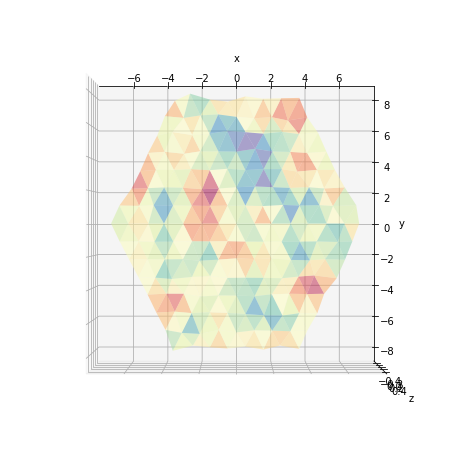

In [220]:
n=7
HD = rt.HexagonalDomain(n)
x,y = HD.x, HD.y
np.random.seed(seed=4)
n_dist = np.random.normal(loc=0,scale = np.sqrt(rtc.sigma),size = x.shape[0])
HD.get_nodes(n_dist) # will add the attributes n_dist and nodes_dict to class
triang = mpl.tri.Triangulation(x, y) ## Triangulate parameter space to determine the triangles using a Delaunay triangulation

fig, axes = plt.subplots(subplot_kw={'projection': '3d'},figsize=(8,30))
axes.view_init(elev=90, azim=270)
axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')
axes.plot_trisurf(triang,n_dist, linewidth=0.2, antialiased=True,cmap=plt.cm.Spectral,alpha=0.5) #3d surface
plt.show()

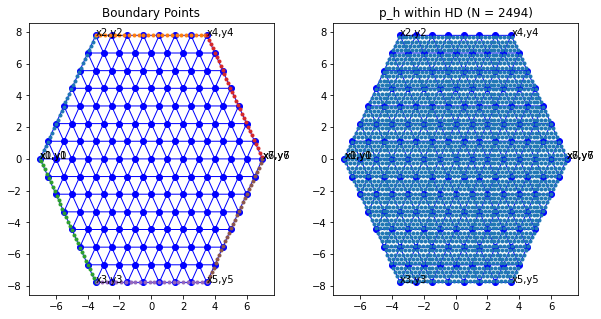

In [221]:
BP = rt.BoundaryPoints(HD,solar_altitude = 70,azimuth = 30, step = 0.3)

fig1, ax1 = plt.subplots(1,2,figsize=(10,5))
ax1[0].set_aspect('equal')
ax1[0].triplot(triang, 'bo-', lw=1)
for index,c in enumerate(HD.corner_points):
    ax1[0].annotate('x{},y{}'.format(index,index),xy=(c[0],c[1]))
ax1[0].set_title('Boundary Points')
for v in BP.get_boundary_points().values():
    ax1[0].plot([i[0] for i in v],[i[1] for i in v],'.')

ax1[1].set_aspect('equal')
ax1[1].triplot(triang, 'bo-', lw=1)
for index,c in enumerate(HD.corner_points):
    ax1[1].annotate('x{},y{}'.format(index,index),xy=(c[0],c[1]))

points_within_HD = BP.get_points_within_HD()
ax1[1].plot([i[0] for i in points_within_HD],[i[1] for i in points_within_HD],'.')
ax1[1].set_title('p_h within HD (N = {})'.format(len(points_within_HD)))
plt.show()

In [148]:
#initialisation of parameters
# daughter rays are automatically saved
solar_altitude=70
azimuth=30
n = 7
step = 0.3
rt.RayTrace(solar_altitude=solar_altitude,
    azimuth=azimuth,
    save_fp=join(r"D:\PAKHUIYING\Image_processing\wave_simulation","save_DR"),
    prefix = "solaralt{}_azimuth{}".format(solar_altitude,azimuth),
    n = n,
    step = step)

Rays to trace:: 2494it [00:06, 364.32it/s]


In [149]:
# load saved daughter rays
data_list = rt.load_daughter_rays(
    save_fp = join(r"D:\PAKHUIYING\Image_processing\wave_simulation","save_DR"))

### Quantify number of multiple scattering

In [219]:
rt.multiple_scattering(data_list,thresh=4)

[0.48115477145148355]

In [230]:
{k:len(v) for k,v in data_list[0].items() if len(v) > 2}

{2: 3,
 12: 3,
 18: 3,
 82: 3,
 131: 6,
 134: 3,
 195: 8,
 203: 3,
 204: 3,
 216: 4,
 248: 3,
 269: 3,
 310: 3,
 325: 4,
 377: 6,
 378: 3,
 386: 4,
 390: 4,
 410: 3,
 458: 3,
 494: 3,
 532: 3,
 561: 4,
 562: 3,
 566: 4,
 568: 3,
 590: 3,
 674: 3,
 788: 9,
 856: 3,
 884: 3,
 926: 3,
 1010: 3,
 1077: 3,
 1096: 3,
 1102: 3,
 1186: 3,
 1286: 3,
 1314: 5,
 1333: 3,
 1362: 3,
 1386: 4,
 1433: 3,
 1458: 3,
 1474: 3,
 1482: 3,
 1548: 4,
 1550: 3,
 1566: 3,
 1604: 4,
 1646: 3,
 1664: 3,
 1723: 3,
 1746: 5,
 1762: 5,
 1766: 3,
 1791: 3,
 1807: 3,
 1839: 5,
 1854: 3,
 1888: 3,
 1893: 4,
 1902: 3,
 1943: 5,
 1952: 6,
 1958: 3,
 2008: 3,
 2069: 4,
 2101: 3,
 2157: 5,
 2170: 3,
 2227: 3,
 2267: 4,
 2274: 4,
 2379: 4,
 2382: 5,
 2384: 3,
 2444: 3}

### Plot daughter rays

In [247]:
for k,v in data_list[0][566].items():
    print(k,v['DR'].keys())
    # print(v['WF'].keys())

0 dict_keys(['p_prime', 'xi_prime', 'theta_r', 'theta_t', 'xi_r', 'xi_t', 'fresnel_reflectance', 'fresnel_transmittance'])
1 dict_keys(['p_prime', 'xi_prime', 'theta_r', 'theta_t', 'xi_r', 'xi_t', 'fresnel_reflectance', 'fresnel_transmittance'])
2 dict_keys(['p_prime', 'xi_prime', 'theta_r', 'xi_r'])
3 dict_keys(['p_prime', 'xi_prime', 'theta_r', 'xi_r'])


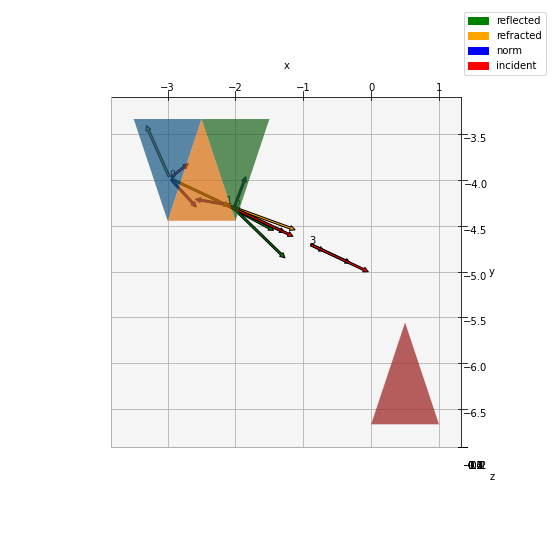

In [246]:
rt.plot_daughter_rays(data_list[0][566],elev=90,azim=270) #195

# Glitter patterns

The sun's glitter pattern on the sea surface has long been used as a tool for deducing the slope statistics of the sea surface (e.g. Cox and Munk)

In this notebook, the sea surface statistics are given, and the glitter pattern is generated by direct ray tracing on a set of sea surface realisations.

An observer in an aircraft or at point $P$ aims a camera at the glitter pattern on the water surface and takes a photograph. The photograph is usually developed so that it has the horizon toward the top and the nadir toward the bottom. Stating the camera's viewing angle (field of view) gives the angular extent of the glitter pattern in nature.

Associated with a point light source are its specular reflection and transmission directions. These are the directions of the reflected and transmitted rays generated when the incoming ray $\xi'$ strikes a surface. The initial $\xi'$ and specular ray path $a$ lie in the same vertical plane.

For the numerical simulation of glitter pattern photographs, we will use coordinate systems based around these specular directions. The optical axes of cameras are aligned along the specular ray paths, and the cameras point toward the specular point on the ocean surface.

The camera angle $\theta_c$ is $\theta_s'$, the angle of reflection for a level surface. The camera angle is $\theta_c = \arcsin(\sin \theta_s'/m)$, the angle of refraction for a flat horizontal water surface

![sun based coordinate system](images/sun-based%20coordinate%20system.png)

Sun-based x-y-z coordinate system used in defining the image plane by simulating a photograph of the glitter pattern on the water surface. $P$ locates the camera film image plane a distance $f$ along $a$ from $S$, the specular reflection point on the sea surface. $t$ is the image of ray $\xi$ from $S$.

### Image plane

We now introduce the image plane. This plane can be thought of as the plane of the film in a camera. With the camera at $P$, we choose a sun-based coordinate system $x-y-z$ centered at the camera's specular point $S$ on the water surface. The unit vector $x$ direction is chosen so that the incoming rays $\xi' = (\xi_x',\xi_y',\xi_z')$ always have $\xi_x' > 0$ and $\xi_y' = 0$. The unit vector $z$ axis is vertical upward and $y$ is chosen so that $y = z \times x$. The camera axis direction $a$ is chosen to be the specular reflection ($\xi_r$) or refraction ($\xi_t$) direction, depending on the case study.

![camera position](images/camera%20position.png)
Camera positions for viewing the four types of glitter patterns

# Test air-incident case

xi_prime dot norm: -0.87
angle of incidence: 150.60
[0 0 0]
[ 0.66666667  0.33333333 -0.66666667]
[-0.40600769  0.02537548  0.91351729]


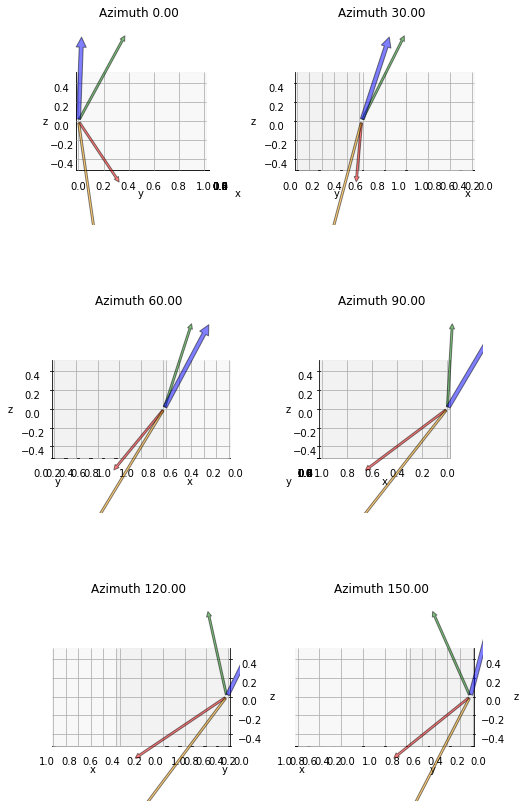

In [62]:
t_3d = np.array([0,0,0])
xi_prime_3d = np.array([1,0.5,-1])/np.linalg.norm(np.array([1,0.5,-1]))
n_3d = np.array([-0.4,0.025,0.9])/np.linalg.norm(np.array([-0.4,0.025,0.9]))
print('xi_prime dot norm: {:.2f}'.format(np.dot(xi_prime_3d,n_3d)))
print('angle of incidence: {:.2f}'.format(np.arccos(np.dot(xi_prime_3d,n_3d))/np.pi*180))

# t_3d = v.target
# xi_prime_3d = xi_prime
# n_3d = v.norm
print(t_3d)
print(xi_prime_3d)
print(n_3d)
m = 4/3
xi_r = xi_prime_3d - 2*np.dot(xi_prime_3d,n_3d)*n_3d
c = np.dot(n_3d,xi_prime_3d) - (np.dot(xi_prime_3d,n_3d)**2 + m**2 -1)**0.5
xi_t = (xi_prime_3d + c*n_3d)/m

views = [(0 ,i) for i in np.arange(0,180,step=30)]
fig, axes = plt.subplots(ceil(len(views)/2),2,subplot_kw={'projection': '3d'},figsize=(8,15))
for angles,ax in zip(views, axes.flatten()):
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_zlim(-0.5,0.5)
    ax.set_proj_type('ortho')
    ax.view_init(elev=angles[0], azim=angles[1])
    ax.set_title('Azimuth {:.2f}'.format(angles[1]))
    # ax.arrow3D(p_prime[0],p_prime[1],p_prime[2],
    #     dx = t_3d[0] - p_prime[0],
    #     dy = t_3d[1] - p_prime[1],
    #     dz = t_3d[2] - p_prime[2],
    #     mutation_scale=10,fc = 'red',alpha=0.5)
    ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
        dx = xi_prime_3d[0],
        dy = xi_prime_3d[1],
        dz = xi_prime_3d[2],
        mutation_scale=10,fc = 'red',alpha=0.5)
    ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
        dx = xi_r[0],
        dy = xi_r[1],
        dz = xi_r[2],mutation_scale=10,fc = 'green',alpha=0.5)
    ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
        dx = xi_t[0],
        dy = xi_t[1],
        dz = xi_t[2],mutation_scale=10,fc = 'orange',alpha=0.5)
    ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
        dx = n_3d[0],
        dy = n_3d[1],
        dz = n_3d[2],mutation_scale=20,fc = 'blue',alpha=0.5)

plt.show()



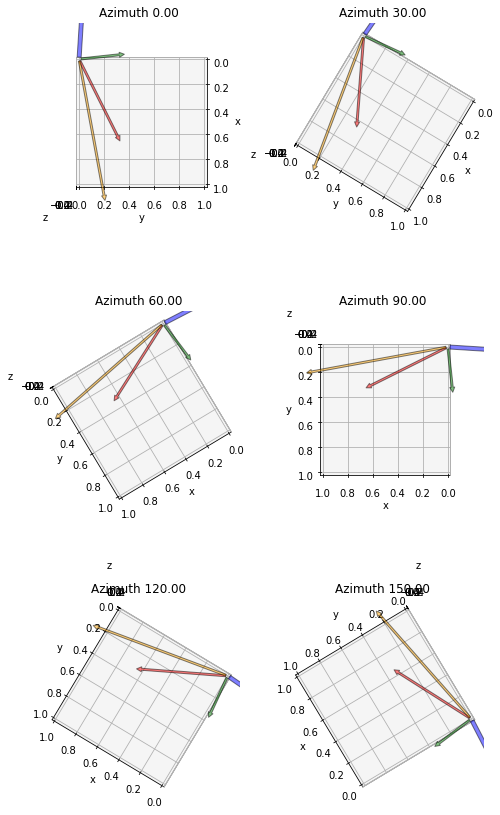

In [63]:
views = [(90 ,i) for i in np.arange(0,180,step=30)]
fig, axes = plt.subplots(ceil(len(views)/2),2,subplot_kw={'projection': '3d'},figsize=(8,15))
for angles,ax in zip(views, axes.flatten()):
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_zlim(-0.5,0.5)
    ax.set_proj_type('ortho')
    ax.view_init(elev=angles[0], azim=angles[1])
    ax.set_title('Azimuth {:.2f}'.format(angles[1]))
    # ax.arrow3D(p_prime[0],p_prime[1],p_prime[2],
    #     dx = t_3d[0] - p_prime[0],
    #     dy = t_3d[1] - p_prime[1],
    #     dz = t_3d[2] - p_prime[2],
    #     mutation_scale=10,fc = 'red',alpha=0.5)
    ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
        dx = xi_prime_3d[0],
        dy = xi_prime_3d[1],
        dz = xi_prime_3d[2],
        mutation_scale=10,fc = 'red',alpha=0.5)
    ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
        dx = xi_r[0],
        dy = xi_r[1],
        dz = xi_r[2],mutation_scale=10,fc = 'green',alpha=0.5)
    ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
        dx = xi_t[0],
        dy = xi_t[1],
        dz = xi_t[2],mutation_scale=10,fc = 'orange',alpha=0.5)
    ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
        dx = n_3d[0],
        dy = n_3d[1],
        dz = n_3d[2],mutation_scale=20,fc = 'blue',alpha=0.5)

plt.show()

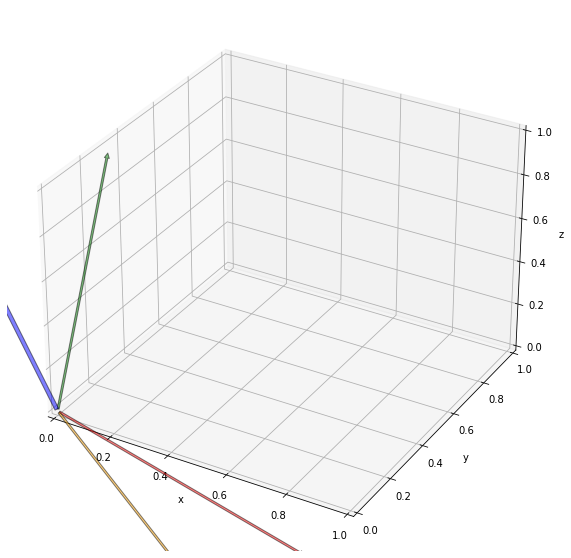

In [64]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
    dx = xi_prime_3d[0],
    dy = xi_prime_3d[1],
    dz = xi_prime_3d[2],
    mutation_scale=10,fc = 'red',alpha=0.5)
ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
    dx = xi_r[0],
    dy = xi_r[1],
    dz = xi_r[2],mutation_scale=10,fc = 'green',alpha=0.5)
ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
    dx = xi_t[0],
    dy = xi_t[1],
    dz = xi_t[2],mutation_scale=10,fc = 'orange',alpha=0.5)
ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
    dx = n_3d[0],
    dy = n_3d[1],
    dz = n_3d[2],mutation_scale=20,fc = 'blue',alpha=0.5)

plt.show()

# Water-incident case

xi_prime dot norm: 0.81
angle of incidence: 35.44
[0 0 0]
[0.19518001 0.09759001 0.97590007]
[-0.40600769  0.02537548  0.91351729]


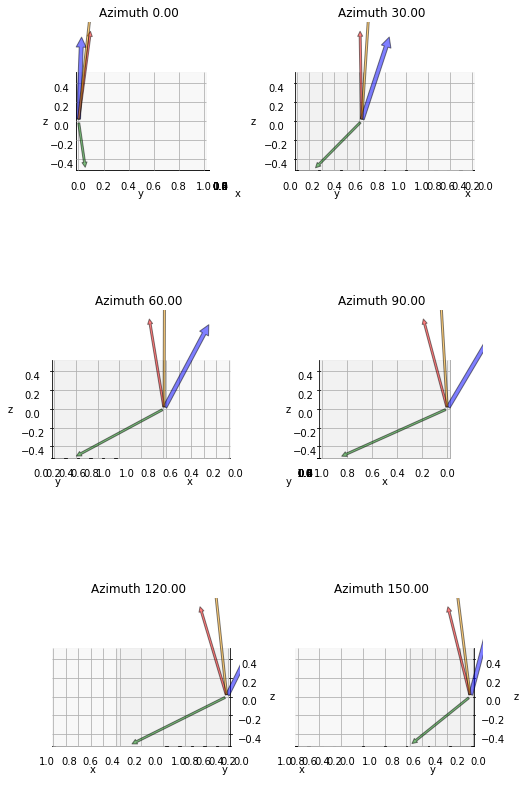

In [65]:
critical_angle = np.arcsin(1/m)
t_3d = np.array([0,0,0])
xi_prime_3d = np.array([1,0.5,5])
xi_prime_3d = xi_prime_3d/np.linalg.norm(xi_prime_3d)
n_3d = np.array([-0.4,0.025,0.9])/np.linalg.norm(np.array([-0.4,0.025,0.9]))
print('xi_prime dot norm: {:.2f}'.format(np.dot(xi_prime_3d,n_3d)))
theta_prime =  np.arccos(np.dot(xi_prime_3d,n_3d))
print('angle of incidence: {:.2f}'.format(theta_prime/np.pi*180))
# t_3d = v.target
# xi_prime_3d = xi_prime
# n_3d = v.norm
print(t_3d)
print(xi_prime_3d)
print(n_3d)
m = 4/3
xi_r = xi_prime_3d - 2*np.dot(xi_prime_3d,n_3d)*n_3d

if theta_prime < critical_angle:
    c = np.dot(m*xi_prime_3d,n_3d) - (np.dot(m*xi_prime_3d,n_3d)**2 - m**2 + 1)**0.5
    xi_t = m*xi_prime_3d + c*n_3d
else:
    c = xi_t = None

views = [(0 ,i) for i in np.arange(0,180,step=30)]
fig, axes = plt.subplots(ceil(len(views)/2),2,subplot_kw={'projection': '3d'},figsize=(8,15))
for angles,ax in zip(views, axes.flatten()):
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_zlim(-0.5,0.5)
    ax.set_proj_type('ortho')
    ax.view_init(elev=angles[0], azim=angles[1])
    ax.set_title('Azimuth {:.2f}'.format(angles[1]))
    # ax.arrow3D(p_prime[0],p_prime[1],p_prime[2],
    #     dx = t_3d[0] - p_prime[0],
    #     dy = t_3d[1] - p_prime[1],
    #     dz = t_3d[2] - p_prime[2],
    #     mutation_scale=10,fc = 'red',alpha=0.5)
    ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
        dx = xi_prime_3d[0],
        dy = xi_prime_3d[1],
        dz = xi_prime_3d[2],
        mutation_scale=10,fc = 'red',alpha=0.5)
    ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
        dx = xi_r[0],
        dy = xi_r[1],
        dz = xi_r[2],mutation_scale=10,fc = 'green',alpha=0.5)

    ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
        dx = n_3d[0],
        dy = n_3d[1],
        dz = n_3d[2],mutation_scale=20,fc = 'blue',alpha=0.5)
    
    if (c is not None) and (xi_t is not None):
        ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
            dx = xi_t[0],
            dy = xi_t[1],
            dz = xi_t[2],mutation_scale=10,fc = 'orange',alpha=0.5)

plt.show()



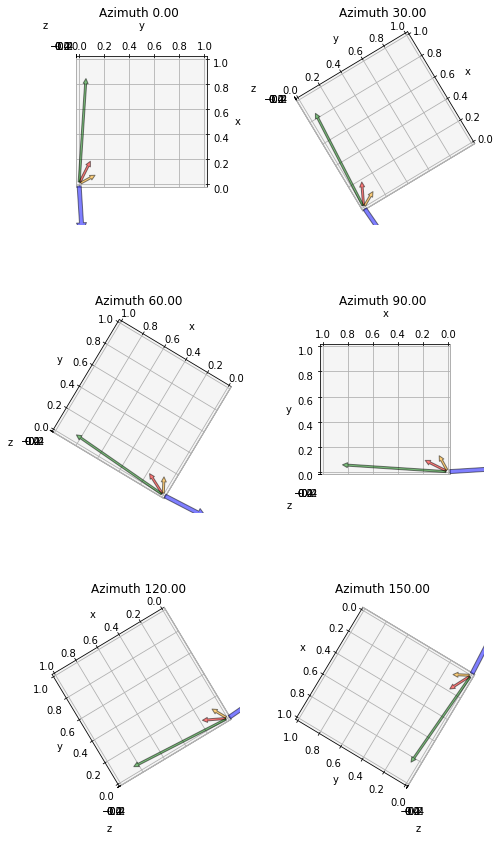

In [66]:
views = [(-90 ,i) for i in np.arange(0,180,step=30)]
fig, axes = plt.subplots(ceil(len(views)/2),2,subplot_kw={'projection': '3d'},figsize=(8,15))
for angles,ax in zip(views, axes.flatten()):
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_zlim(-0.5,0.5)
    ax.set_proj_type('ortho')
    ax.view_init(elev=angles[0], azim=angles[1])
    ax.set_title('Azimuth {:.2f}'.format(angles[1]))
    # ax.arrow3D(p_prime[0],p_prime[1],p_prime[2],
    #     dx = t_3d[0] - p_prime[0],
    #     dy = t_3d[1] - p_prime[1],
    #     dz = t_3d[2] - p_prime[2],
    #     mutation_scale=10,fc = 'red',alpha=0.5)
    ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
        dx = xi_prime_3d[0],
        dy = xi_prime_3d[1],
        dz = xi_prime_3d[2],
        mutation_scale=10,fc = 'red',alpha=0.5)
    ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
        dx = xi_r[0],
        dy = xi_r[1],
        dz = xi_r[2],mutation_scale=10,fc = 'green',alpha=0.5)

    ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
        dx = n_3d[0],
        dy = n_3d[1],
        dz = n_3d[2],mutation_scale=20,fc = 'blue',alpha=0.5)
    
    if (c is not None) and (xi_t is not None):
        ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
            dx = xi_t[0],
            dy = xi_t[1],
            dz = xi_t[2],mutation_scale=10,fc = 'orange',alpha=0.5)

plt.show()

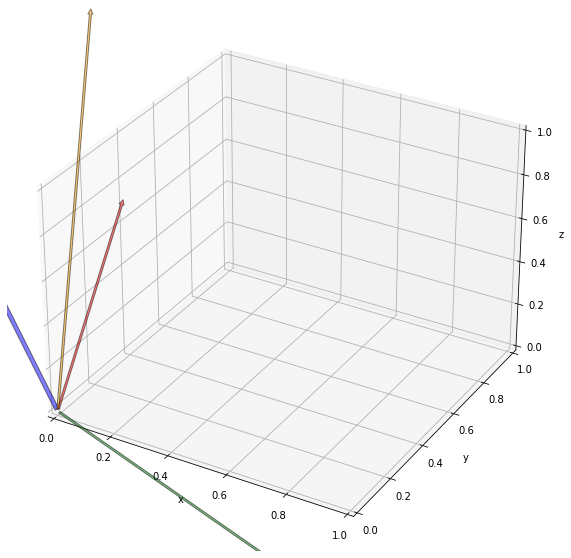

In [67]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
    dx = xi_prime_3d[0],
    dy = xi_prime_3d[1],
    dz = xi_prime_3d[2],
    mutation_scale=10,fc = 'red',alpha=0.5)
ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
    dx = xi_r[0],
    dy = xi_r[1],
    dz = xi_r[2],mutation_scale=10,fc = 'green',alpha=0.5)
ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
    dx = n_3d[0],
    dy = n_3d[1],
    dz = n_3d[2],mutation_scale=20,fc = 'blue',alpha=0.5)
if (c is not None) and (xi_t is not None):
    ax.arrow3D(t_3d[0],t_3d[1],t_3d[2],
        dx = xi_t[0],
        dy = xi_t[1],
        dz = xi_t[2],mutation_scale=10,fc = 'orange',alpha=0.5)

plt.show()